<img src='https://investigaciones.uniandes.edu.co/wp-content/themes/vicerrectoria001/images/logo2.png'>

# Exercise 05


## Using the example_retail_sales dataset:
- Standarize the dataset using np.log
- Using prophet forescast the next 6 months of the sales logarithm
- Predict the next 6 months of sales

### Integrantes
<ul>
    <li>Angela Fernanda Romero Fonseca - 201819276</li>
    <li>Carlos Francisco Silva Ortiz - 201920463</li>
    <li>Daniela Carolina Sanabria Guerrero -201116798</li>
    <li>Juan Camilo Florez - 201620135</li>
</ul>

a) Importamos el Dataset y posteriormente calculamos el logaritmo de las ventas como se menciona en el enunciado

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

passengers = pd.read_csv('datasets\example_retail_sales.csv')
df = pd.DataFrame(passengers)
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,1992-01-01,11.893934
1,1992-02-01,11.898725
2,1992-03-01,11.978770
3,1992-04-01,12.005601
4,1992-05-01,12.043954


b) Creamos el modelo de Prophet

In [4]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error
import os
os.environ["NUMEXPR_MAX_THREADS"]="16"

#Como la información tiene detalle anual, removemos las tendencias semanales y diarias
m = Prophet(weekly_seasonality=False, daily_seasonality=False)
m.fit(df);

b) Luego de preparar la información pronosticamos los 6 meses requeridos, adicionalmente reescalamos la serie en la variable yhat_rescaled

In [5]:
future = m.make_future_dataframe(periods= 6, freq='M')
forecast = m.predict(future)
forecast['yhat_rescaled'] = np.exp(forecast['yhat'])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','yhat_rescaled']].tail(6)

,ds,yhat,yhat_lower,yhat_upper,yhat_rescaled
293,2016-05-31,13.057744,13.038578,13.076948,468712.181736
294,2016-06-30,13.057717,13.038597,13.078088,468699.597706
295,2016-07-31,13.082380,13.062001,13.101624,480402.830377
296,2016-08-31,13.015577,12.995340,13.037417,449358.772940
297,2016-09-30,13.037937,13.017949,13.058809,459519.554372
298,2016-10-31,13.055811,13.035124,13.077603,467806.938021


Revisamos gráficamente la serie junto los 6 meses de pronástico para validar gráficamente si mantiene el comportamiento

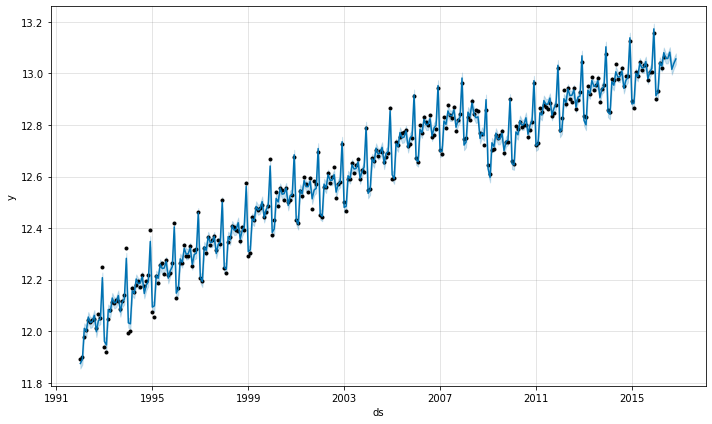

In [6]:
fig1 = m.plot(forecast);

Revisamos los componentes de tendencia y estacionalidad de la serie

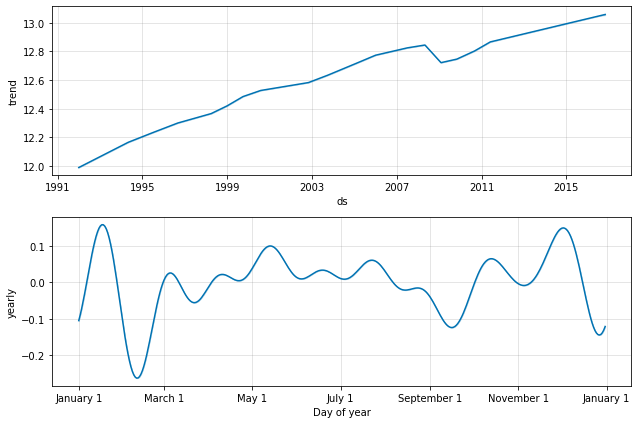

In [7]:
m.plot_components(forecast);

Construimos un modelo prophet y con rolling forecast usando 90% para train, 10% para test para validar el MSE.

In [8]:
size = int(len(df['y']) * 0.9)
train = df[:size]
test = df[size:]
predictions = np.zeros(len(test))
predictions_rescaled = np.zeros(len(test))

In [9]:
for t in range(len(test)):
    m = Prophet(weekly_seasonality=False,daily_seasonality=False)
    m.fit(train)
    future=pd.DataFrame(df['ds'][:(size+t+1)])
    #future = m.make_future_dataframe(periods=1, freq='M')
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']].tail(1)
    forecast.columns = ['ds','y']
    train = train.append(forecast)
    predictions[t] = forecast[['y']].values
    predictions_rescaled[t] = np.exp(forecast[['y']].values)
mse_rescaled = mean_squared_error(np.exp(test['y'].values), predictions_rescaled) ** 0.5
mse = mean_squared_error(test['y'].values, predictions) ** 0.5
print('MSE: %.2f' % mse)
print('MSE Rescaled: %.2f' % mse_rescaled)

MSE: 0.04
MSE Rescaled: 20333.91
